# Planetary gaps

This notebook discusses ways to impose gaps on the surface density profiles. Since `DustPy` is one-dimensional it is difficult to self-consistently model gaps carved by planets into the protoplanetary disk. One way of doing this, would be to set the gas surface density profile to analytical gap profile taken from multi-dimensional hydrodynamical simulation. However, in this case the gas would be static and non-evolving.

Another way would be to utilize the fact that the product of viscosity and gas surface density is constant in steady state. 

$\nu \Sigma_\mathrm{gas} = \mathrm{const.}$

Imposing the inverse gap profile onto the viscosity would therefore create the desired gap profile on the gas surface density. Since the viscosity is proportial to the $\alpha$-parameter, we therefore impose the inverse gap profile onto $\alpha$.

This notebook adds gaps carved by the Solar System giant planet to `DustPy` simulations with different gap shapes. We therefore create a dictionary with the masses of the planets in g and their semi-major axis in cm.

In [1]:
import dustpy.constants as c

In [2]:
planets = {
    "jupiter": {
        "a": 5.2038 * c.au,
        "M": 317.8 * c.M_earth,
    },
    "saturn": {
        "a": 9.5826 * c.au,
        "M": 95.159 * c.M_earth,
    },
    "uranus": {
        "a": 19.19126 * c.au,
        "M": 14.536 * c.M_earth,
    },
    "neptune": {
        "a": 30.07 * c.au,
        "M": 17.147 * c.M_earth,
    },
}

## Kanagawa et al. (2017)

`dustpylib` contains the analytical function of [Kanagawa et al. (2017)](https://doi.org/10.1093/pasj/psx114) fitted to gap profiles obtained from hydrodynamical simulations.

We first create a `DustPy` simulation object.

In [3]:
from dustpy import Simulation

In [4]:
s = Simulation()

Before we initialize the simulation object, we refine the radial grid around the planet locations.

In [5]:
from dustpylib.grid.refinement import refine_radial_local
import numpy as np

In [6]:
ri = np.geomspace(s.ini.grid.rmin, s.ini.grid.rmax, s.ini.grid.Nr)
for planet in planets.values():
    ri = refine_radial_local(ri, planet["a"], num=3)

In [7]:
s.grid.ri = ri

Now we can initialize the simulation object with the new grid.

In [8]:
s.initialize()

In the next step we add a group for the planets and add their masses as fields.

In [9]:
s.addgroup("planets", description="Planets")
for name, planet in planets.items():
    s.planets.addgroup(name, description="Planet {}".format(name.title()))
    s.planets.__dict__[name].addfield("M", planet["M"], description="Mass in g")
    s.planets.__dict__[name].addfield("a", planet["a"], description="Semi-major axis in cm")

In [10]:
s.planets

Group (Planets)
---------------
    jupiter      : Group (Planet Jupiter)
    neptune      : Group (Planet Neptune)
    saturn       : Group (Planet Saturn)
    uranus       : Group (Planet Uranus)
  -----

In [11]:
s.planets.jupiter

Group (Planet Jupiter)
----------------------
    a            : Field (Semi-major axis in cm)
    M            : Field (Mass in g)
  -----

Since we are going to impose the inverse gap profile on $\alpha$, we need to copy and store the unperturbed $\alpha$-profile for later usage.

In [12]:
alpha0 = s.gas.alpha.copy()

In the next step we need to define an updater function for $\alpha$, which imposes the inverse gap profile. For this we can use the `kanagawa2017()` function of `dustpylib`.

In [13]:
from dustpylib.substructures.gaps import kanagawa2017
from scipy.interpolate import interp1d

In [14]:
def alpha(s):
    # Unperturbed profile
    alpha = alpha0.copy()
    # Iteration over all planets
    for name, planet in s.planets.__dict__.items():
        # Skip hidden fields:
        if name.startswith("_"):
            continue
        # Dimensionless planet mass
        q = planet.M/s.star.M
        # Interpolation of aspect ratio and alpha0 onto planet position
        f_h = interp1d(s.grid.r, s.gas.Hp/s.grid.r)
        h = f_h(planet.a)
        f_alp = interp1d(s.grid.r, alpha0)
        alp = f_alp(planet.a)
        # Inverse alpha-profile
        alpha /= kanagawa2017(s.grid.r, planet.a, q, h, alp)
    return alpha

This function can now be added as updater of the $\alpha$ field.

In [15]:
s.gas.alpha.updater = alpha

After updating the simulation object, $\alpha$ should have the desired profile.

In [16]:
s.update()

In [17]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

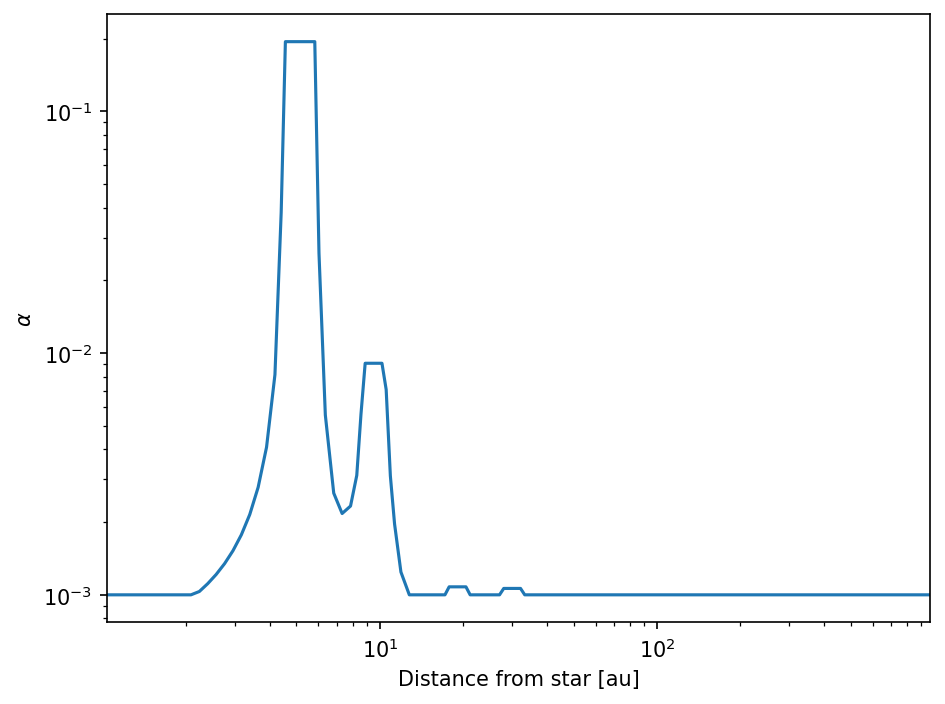

In [18]:
fig, ax = plt.subplots()
ax.loglog(s.grid.r/c.au, s.gas.alpha)
ax.set_xlim(s.grid.r[0]/c.au, s.grid.r[-1]/c.au)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel(r"$\alpha$")
fig.tight_layout()

The simulation would now be ready to go by executing `s.run()` and the gap profile would be imposed on the gas surface density on viscous time scales.

But we could also impose this profile on the gas and dust surface densities from the beginning.

In [19]:
s.gas.Sigma[...] /= s.gas.alpha/alpha0
s.dust.Sigma[...] /= (s.gas.alpha/alpha0)[:, None]

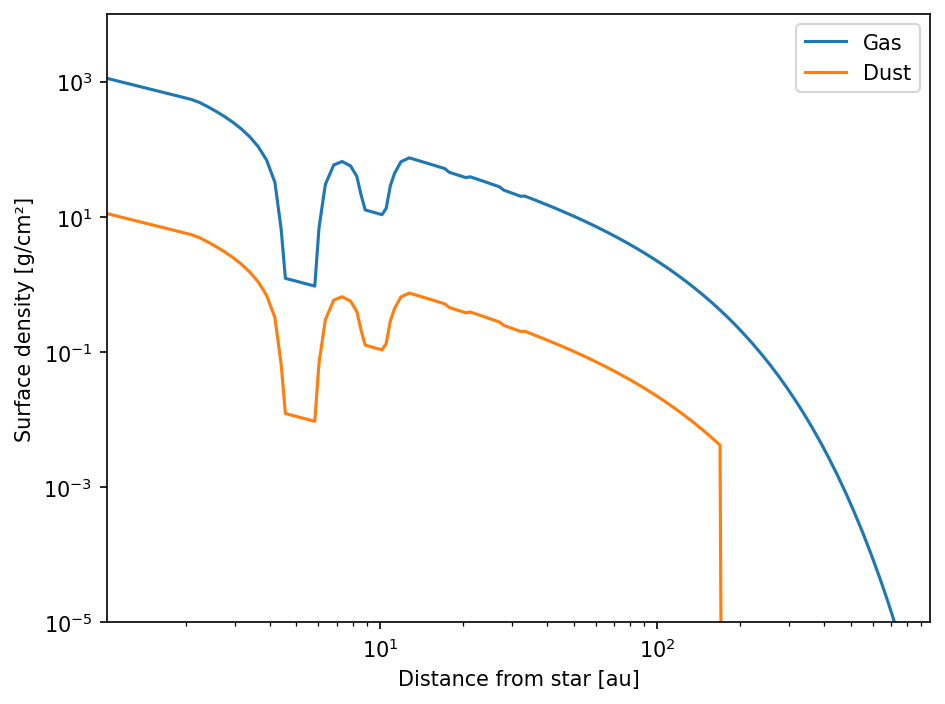

In [20]:
fig, ax = plt.subplots()
ax.loglog(s.grid.r/c.au, s.gas.Sigma, label="Gas")
ax.loglog(s.grid.r/c.au, s.dust.Sigma.sum(-1), label="Dust")
ax.set_xlim(s.grid.r[0]/c.au, s.grid.r[-1]/c.au)
ax.set_ylim(1.e-5, 1.e4)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Surface density [g/cm²]")
ax.legend()
fig.tight_layout()

## Duffell (2020)

`dustpylib` furthermore contains the empirically derived gap shapes of [Duffell (2020)](https://doi.org/10.3847/1538-4357/ab5b0f).

This example analogous to the example above and implements the Solar System giants to a `DustPy` simulation.

In [21]:
from dustpy import Simulation

In [22]:
s = Simulation()

Before we initialize the simulation object, we refine the radial grid around the planet locations.

In [23]:
from dustpylib.grid.refinement import refine_radial_local
import numpy as np

In [24]:
ri = np.geomspace(s.ini.grid.rmin, s.ini.grid.rmax, s.ini.grid.Nr)
for planet in planets.values():
    ri = refine_radial_local(ri, planet["a"], num=3)

In [25]:
s.grid.ri = ri

Now we can initialize the simulation object with the new grid.

In [26]:
s.initialize()

In the next step we add a group for the planets and add their masses as fields.

In [27]:
s.addgroup("planets", description="Planets")
for name, planet in planets.items():
    s.planets.addgroup(name, description="Planet {}".format(name.title()))
    s.planets.__dict__[name].addfield("M", planet["M"], description="Mass in g")
    s.planets.__dict__[name].addfield("a", planet["a"], description="Semi-major axis in cm")

In [28]:
s.planets

Group (Planets)
---------------
    jupiter      : Group (Planet Jupiter)
    neptune      : Group (Planet Neptune)
    saturn       : Group (Planet Saturn)
    uranus       : Group (Planet Uranus)
  -----

In [29]:
s.planets.jupiter

Group (Planet Jupiter)
----------------------
    a            : Field (Semi-major axis in cm)
    M            : Field (Mass in g)
  -----

Since we are going to impose the inverse gap profile on $\alpha$, we need to copy and store the unperturbed $\alpha$-profile for later usage.

In [30]:
alpha0 = s.gas.alpha.copy()

In the next step we need to define an updater function for $\alpha$, which imposes the inverse gap profile. For this we can use the `duffell2020()` function of `dustpylib`.

In [31]:
from dustpylib.substructures.gaps import duffell2020
from scipy.interpolate import interp1d

In [32]:
def alpha(s):
    # Unperturbed profile
    alpha = alpha0.copy()
    # Iteration over all planets
    for name, p in s.planets.__dict__.items():
        # Skip hidden fields:
        if name.startswith("_"):
            continue
        # Dimensionless planet mass
        q = p.M/s.star.M
        # Interpolation of aspect ratio and alpha0 onto planet position
        f_h = interp1d(s.grid.r, s.gas.Hp/s.grid.r)
        h = f_h(p.a)
        f_alp = interp1d(s.grid.r, alpha0)
        alp = f_alp(p.a)
        # Inverse alpha-profile
        alpha /= duffell2020(s.grid.r, p.a, q, h, alp)
    return alpha

This function can now be added as updater of the $\alpha$ field.

In [33]:
s.gas.alpha.updater = alpha

After updating the simulation object, $\alpha$ should have the desired profile.

In [34]:
s.update()

In [35]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

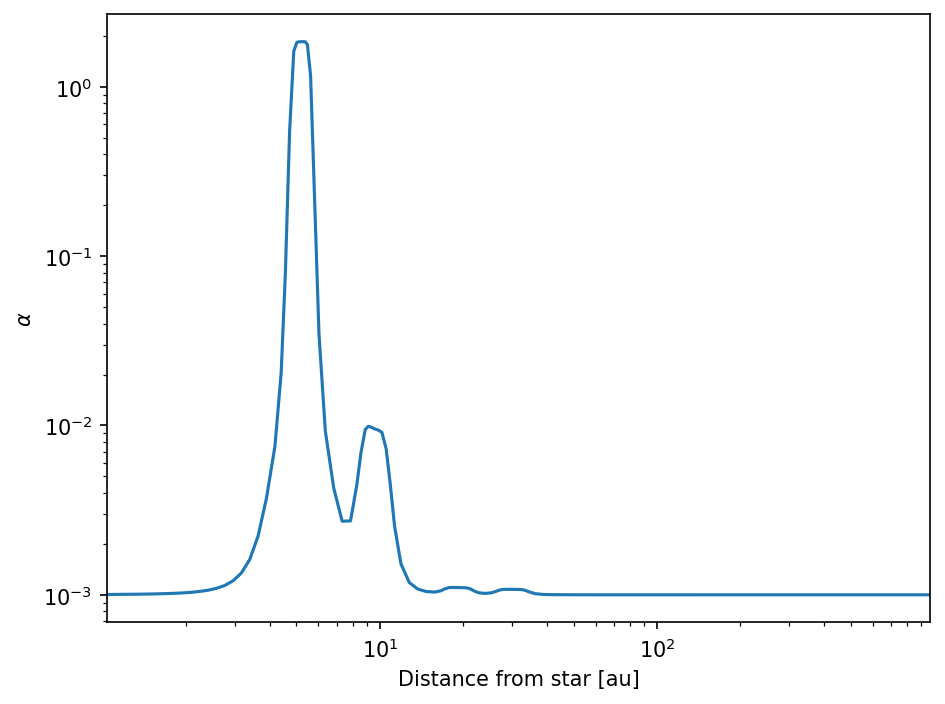

In [36]:
fig, ax = plt.subplots()
ax.loglog(s.grid.r/c.au, s.gas.alpha)
ax.set_xlim(s.grid.r[0]/c.au, s.grid.r[-1]/c.au)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel(r"$\alpha$")
fig.tight_layout()

The simulation would now be ready to go by executing `s.run()` and the gap profile would be imposed on the gas surface density on viscous time scales.

But we could also impose this profile on the gas and dust surface densities from the beginning.

In [37]:
s.gas.Sigma[...] /= s.gas.alpha/alpha0
s.dust.Sigma[...] /= (s.gas.alpha/alpha0)[:, None]

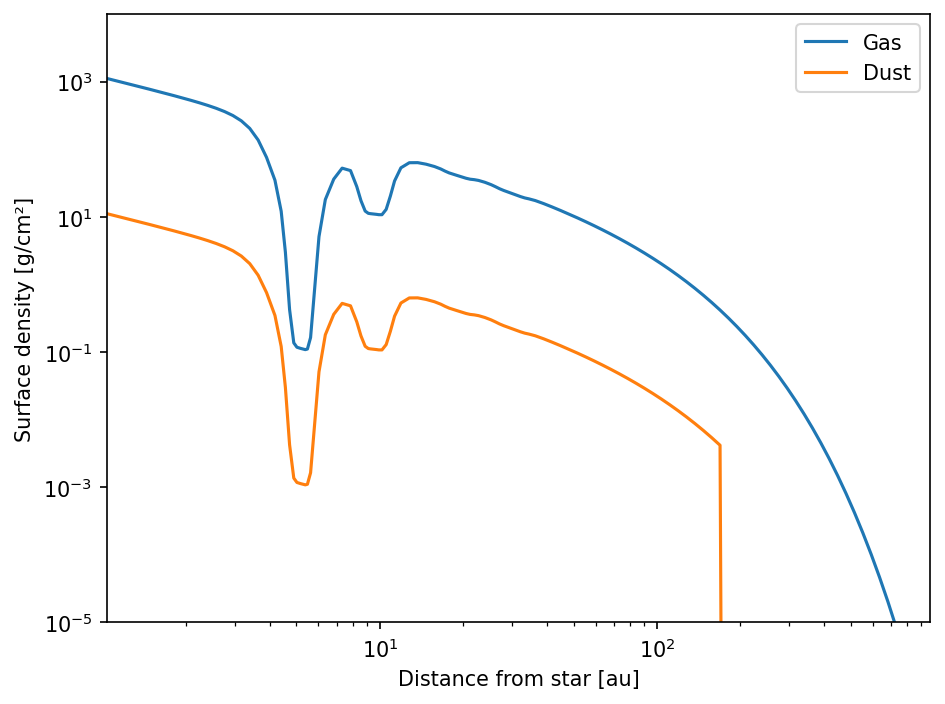

In [38]:
fig, ax = plt.subplots()
ax.loglog(s.grid.r/c.au, s.gas.Sigma, label="Gas")
ax.loglog(s.grid.r/c.au, s.dust.Sigma.sum(-1), label="Dust")
ax.set_xlim(s.grid.r[0]/c.au, s.grid.r[-1]/c.au)
ax.set_ylim(1.e-5, 1.e4)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Surface density [g/cm²]")
ax.legend()
fig.tight_layout()